<a href="https://colab.research.google.com/github/anita-maxwynn/RL/blob/main/960_961_940_954.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
X = individual_household_electric_power_consumption.data.features
y = individual_household_electric_power_consumption.data.targets

# metadata
print(individual_household_electric_power_consumption.metadata)

# variable information
print(individual_household_electric_power_consumption.variables)


/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

In [ ]:
import pandas as pd

df = individual_household_electric_power_consumption.data.features

# Keep the important column and convert non-numeric values to NaN, then drop NaNs
load_series = df["Global_active_power"].replace("?", pd.NA).dropna().astype(float)

print(load_series.head())
print("Length:", len(load_series))

0    4.216
1    5.360
2    5.374
3    5.388
4    3.666
Name: Global_active_power, dtype: float64
Length: 2049280


In [ ]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

df = df.set_index('DateTime')

# Convert 'Global_active_power' to numeric, handling missing values
df['Global_active_power'] = df['Global_active_power'].replace('?', pd.NA).dropna().astype(float)

hourly_load = df['Global_active_power'].resample('1h').mean().dropna()

print(hourly_load.head())

DateTime
2006-12-16 17:00:00    4.222889
2006-12-16 18:00:00    3.632200
2006-12-16 19:00:00    3.400233
2006-12-16 20:00:00    3.268567
2006-12-16 21:00:00    3.056467
Name: Global_active_power, dtype: float64


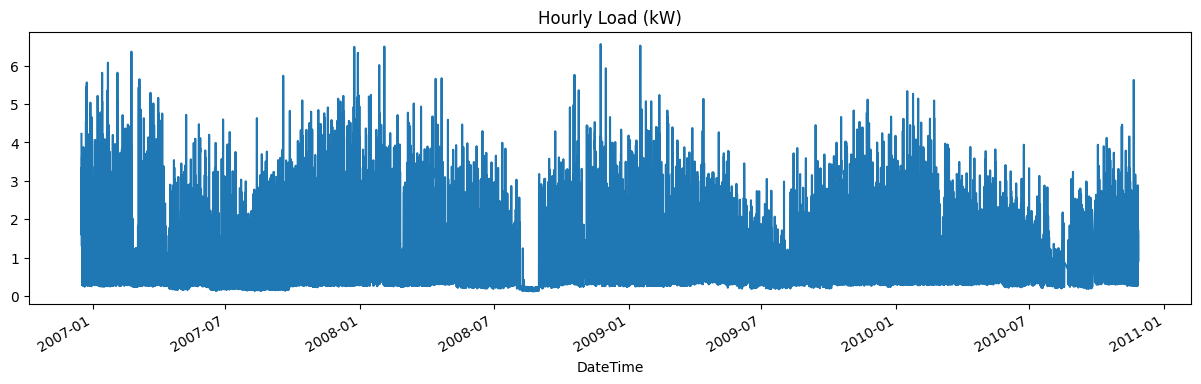

In [ ]:
import matplotlib.pyplot as plt

hourly_load.plot(figsize=(15,4))
plt.title("Hourly Load (kW)")
plt.show()


In [ ]:
# Install pypsa if it's not already installed
!pip install pypsa

In [ ]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt

# Create an empty PyPSA network and initialize with the hourly_load's index as snapshots
network = pypsa.Network(snapshots=hourly_load.index)

# Add a bus to the network
network.add("Bus", "my_bus")

# Add the hourly_load as a Load component, converting kW to MW
network.add("Load", "household_load", bus="my_bus", p_set=hourly_load / 1000) # Convert kW to MW

# Add a generator to the bus with some capacity and marginal cost
# We'll set a high capacity to ensure it can meet the load and a marginal cost
# network.add("Generator", "coal_plant", bus="my_bus",
#             p_nom=100,  # Nominal power in MW
#             p_nom_min=0,
#             marginal_cost=20  # Cost per MWh
#            )

# # Add another generator with higher marginal cost to see dispatch preference
# network.add("Generator", "gas_plant", bus="my_bus",
#             p_nom=50,  # Nominal power in MW
#             p_nom_min=0,
#             marginal_cost=50  # Higher cost per MWh
#            )
network.add("Generator", "coal_plant", bus="my_bus",
            p_nom=0.02,   # 20 kW
            p_nom_min=0,
            marginal_cost=20)

network.add("Generator", "gas_plant", bus="my_bus",
            p_nom=0.02,   # 20 kW
            p_nom_min=0,
            marginal_cost=50)
print("PyPSA Network components added.")

PyPSA Network components added.


Now, let's run the Linear Optimal Power Flow (LOPF) to determine the economic dispatch.

In [ ]:
# Solve the network for optimal dispatch
# This will determine how much each generator produces to meet the load at minimum cost
network.optimize(network.snapshots)

print("Optimal Power Flow solved.")

Index(['my_bus'], dtype='object', name='name')
Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


Optimal Power Flow solved.


Let's visualize the dispatch of the generators and the total load.

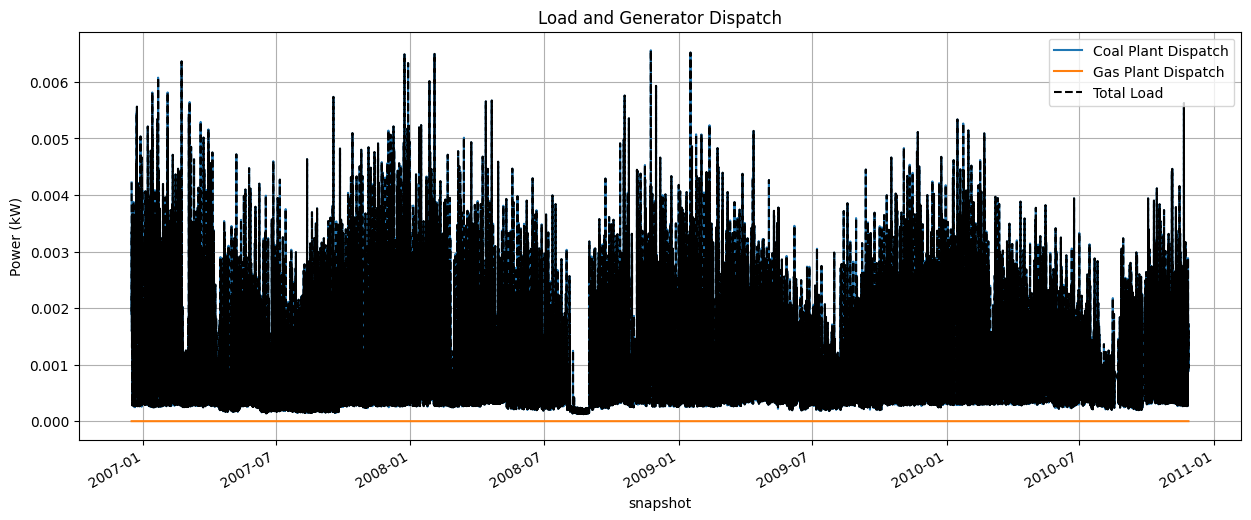

In [ ]:
# Plot generator dispatch and load
fig, ax = plt.subplots(figsize=(15, 6))
network.generators_t.p.plot(ax=ax, title="Generator Dispatch", ylabel="Power (kW)")
network.loads_t.p.plot(ax=ax, style='--', color='black', title="Load and Generator Dispatch", ylabel="Power (kW)")
ax.legend(['Coal Plant Dispatch', 'Gas Plant Dispatch', 'Total Load'])
plt.grid(True)
plt.show()

# You can also inspect other results, for example, the generator production data:
# display(network.generators_t.p.head())
# display(network.loads_t.p.head())

In [ ]:
import gym
from gym import spaces
import numpy as np

class EconomicDispatchEnv(gym.Env):
    def __init__(self, hourly_load):
        super(EconomicDispatchEnv, self).__init__()

        self.load = hourly_load / 1000  # kW → MW
        self.timestamps = list(self.load.index)
        self.t = 0

        # Two generators: coal (cheap), gas (expensive)
        self.gen_costs = np.array([20, 50])  # $/MWh
        self.gen_max = np.array([0.02, 0.02]) # 20kW each

        # Action = fraction of load for generator 1 (0–1)
        self.action_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)

        # Observation: demand
        low = np.array([0], dtype=np.float32)
        high = np.array([self.load.max()], dtype=np.float32)
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        return np.array([self.load.iloc[self.t]], dtype=np.float32), {}

    def step(self, action):
        action = float(action[0])  # fraction for coal plant

        demand = float(self.load.iloc[self.t])

        # Dispatch
        g1 = action * demand
        g2 = (1 - action) * demand

        # Clip to generator limits
        g1 = np.clip(g1, 0, self.gen_max[0])
        g2 = np.clip(g2, 0, self.gen_max[1])

        total_gen = g1 + g2

        # Cost
        cost = g1 * self.gen_costs[0] + g2 * self.gen_costs[1]

        # Penalty for unmet load
        unmet = max(0, demand - total_gen)
        penalty = unmet * 2000  # harsh

        reward = - (cost + penalty)

        # Next timestep
        self.t += 1
        done = self.t >= len(self.load)

        next_obs = np.array([self.load.iloc[self.t-1]], dtype=np.float32)

        info = {"g1": g1, "g2": g2, "cost": cost, "unmet": unmet}

        return next_obs, reward, done, False, info


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [ ]:
!pip install stable-baselines3
!pip install shimmy>=2.0

In [ ]:
from stable_baselines3 import PPO

env = EconomicDispatchEnv(hourly_load)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



-----------------------------
| time/              |      |
|    fps             | 1320 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



------------------------------------------
| time/                   |              |
|    fps                  | 945          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0052079824 |
|    clip_fraction        | 0.0211       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.00102      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.033        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00208     |
|    std                  | 0.995        |
|    value_loss           | 0.283        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 866          |
|    iterations           | 3            |
|    time_e

In [ ]:
obs, info = env.reset()
done = False

results = {"g1": [], "g2": [], "demand": []}

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _, info = env.step(action)
    results["g1"].append(info["g1"])
    results["g2"].append(info["g2"])
    results["demand"].append(float(obs))


/tmp/ipython-input-1870904094.py:11: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



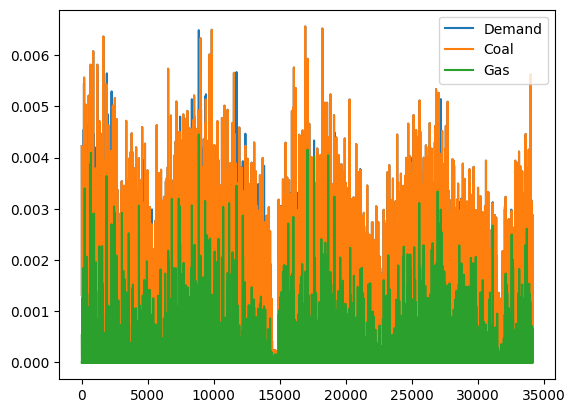

In [ ]:
plt.plot(results["demand"], label="Demand")
plt.plot(results["g1"], label="Coal")
plt.plot(results["g2"], label="Gas")
plt.legend()
plt.show()


In [ ]:
def classical_dispatch_lagrange(demand, gen_max, costs):
    g1_max, g2_max = gen_max
    c1, c2 = costs

    # If generator 1 is always cheaper:
    if c1 < c2:
        g1 = min(demand, g1_max)
        g2 = max(0, demand - g1)
    else:
        g2 = min(demand, g2_max)
        g1 = max(0, demand - g2)

    return g1, g2


# classical results
classical_g1 = []
classical_g2 = []
for d in results["demand"]:
    g1, g2 = classical_dispatch_lagrange(d, env.gen_max, env.gen_costs)
    classical_g1.append(g1)
    classical_g2.append(g2)


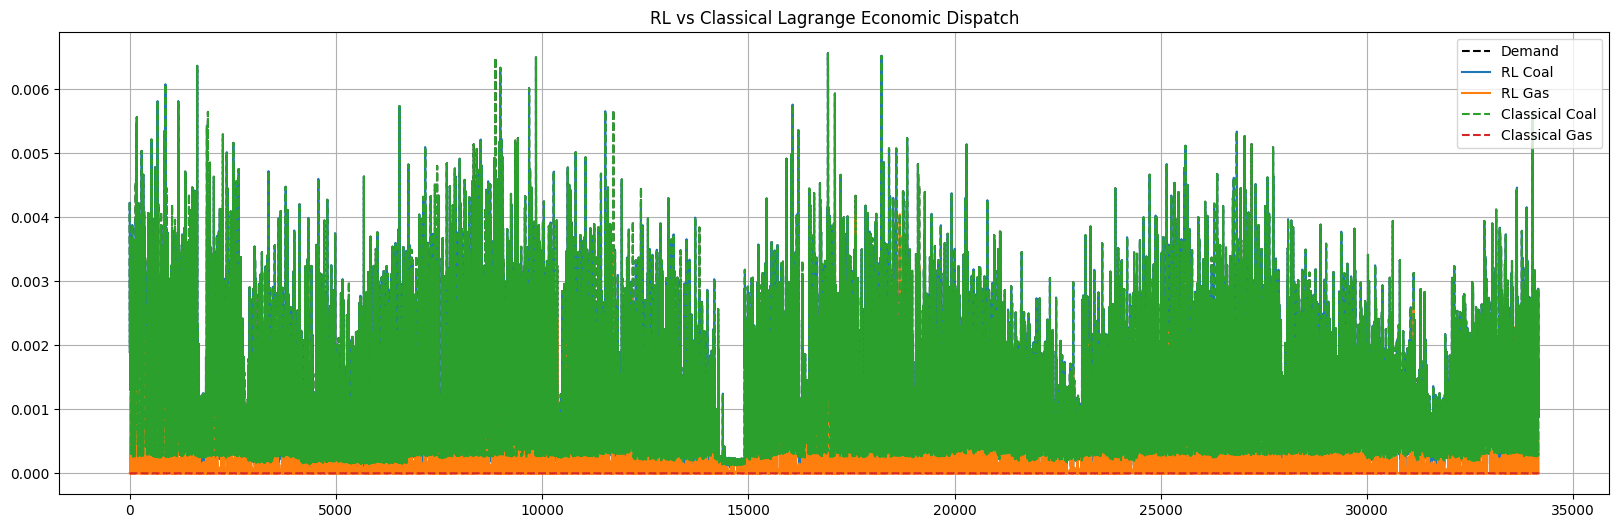

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(results["demand"], label="Demand", linestyle="--", color="black")
plt.plot(results["g1"], label="RL Coal")
plt.plot(results["g2"], label="RL Gas")
plt.plot(classical_g1, label="Classical Coal", linestyle="--")
plt.plot(classical_g2, label="Classical Gas", linestyle="--")
plt.legend()
plt.title("RL vs Classical Lagrange Economic Dispatch")
plt.grid()
plt.show()


In [ ]:
from scipy.optimize import linprog

def classical_lp_dispatch(demand, gen_max, costs):
    c1, c2 = costs
    g1_max, g2_max = gen_max

    # Objective: minimize cost
    c = [c1, c2]

    # Equality constraint: g1 + g2 = demand
    A_eq = [[1, 1]]
    b_eq = [demand]

    # Bounds
    bounds = [(0, g1_max), (0, g2_max)]

    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result.success:
        return result.x
    else:
        return (0, 0)  # fallback

# LP results
lp_g1 = []
lp_g2 = []

for d in results["demand"]:
    g1, g2 = classical_lp_dispatch(d, env.gen_max, env.gen_costs)
    lp_g1.append(g1)
    lp_g2.append(g2)


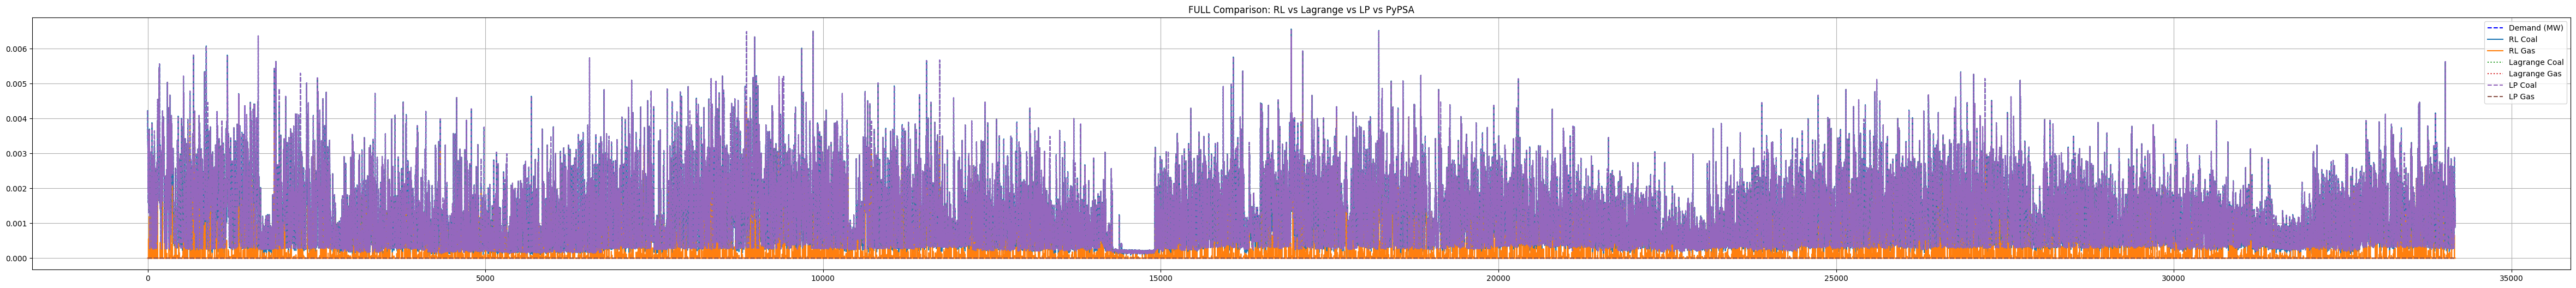

In [ ]:
plt.figure(figsize=(60,6))

plt.plot(results["demand"], label="Demand (MW)", color="blue", linestyle="--")

# RL
plt.plot(results["g1"], label="RL Coal")
plt.plot(results["g2"], label="RL Gas")

# Classical
plt.plot(classical_g1, label="Lagrange Coal", linestyle=":")
plt.plot(classical_g2, label="Lagrange Gas", linestyle=":")

# LP
plt.plot(lp_g1, label="LP Coal", linestyle="--")
plt.plot(lp_g2, label="LP Gas", linestyle="--")

plt.legend()
plt.grid()
plt.title("FULL Comparison: RL vs Lagrange vs LP vs PyPSA")
plt.show()
